# RandomForest and SVM on heat-killed bacterial samples

## Imports

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [3]:
from adjustText import adjust_text
from sklearn.pipeline import Pipeline
from feature_engine.selection import DropDuplicateFeatures
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectKBest, chi2, SelectFromModel
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from pathlib import Path
from datetime import datetime
from sklearn.metrics import ConfusionMatrixDisplay

from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import classification_report
from tqdm import tqdm
import time

from sklearn.metrics import (
    make_scorer,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    accuracy_score,
)
from sklearn.model_selection import StratifiedShuffleSplit
from joblib import parallel_backend
from imblearn.over_sampling import SMOTE

In [4]:
pd.set_option("display.max_columns", 20)
pd.set_option("display.max_rows", 400)
pd.set_option("display.precision", 5)
pd.set_option("display.max_seq_items", 50)
pd.set_option("display.max_seq_items", 50)

## Custom Functions

In [9]:
custom_palette_6 = [
    "#1f77b4",  # Muted Blue
    "#ff7f0e",  # Soft Orange
    "#2ca02c",  # Green
    "#d62728",  # Red
    "#9467bd",  # Purple
    "#17becf",  # Teal/Cyan
]

In [10]:
def make_probability_matrix(model_name, test_pred):
    plt.figure(figsize=(12, 8))

    g = sns.heatmap(test_pred, cmap="YlGnBu")
    g.set_title(f"{model_name} Heat Killed Bacteria predictions", fontsize=15)
    g.set_xlabel("Reference", fontsize=15)
    g.set_ylabel("Sample", fontsize=15, labelpad=10)
    # heat.set_xticklabels(["Negative Control", "Positive Control", "Heat Killed Bacteria"], fontsize=12)
    plt.tight_layout()
    save_fig(f"{model_name}_Heat_Killed_Predictions")
    plt.show()

    return g


def multiclass_roc_auc_score(y_test, y_pred, average="macro") -> float:
    """Returns averaged auc per class"""
    unique_classes = set(y_test)
    roc_auc_dict = {}

    for tested_class in unique_classes:
        other_classes = [x for x in unique_classes if x != tested_class]

        # Marking the current class as 1 and all other classes as 0
        binary_y_test = [0 if x in other_classes else 1 for x in y_test]
        binary_y_pred = [0 if x in other_classes else 1 for x in y_pred]

        roc_auc = roc_auc_score(binary_y_test, binary_y_pred, average=average)

        roc_auc_dict[tested_class] = roc_auc

    return sum(roc_auc_dict.values()) / len(roc_auc_dict.values())


def make_score(y_test, y_pred) -> zip:
    accuracy, precision, recall, f1, roc_auc = (
        accuracy_score(y_test, y_pred),
        precision_score(y_test, y_pred, average="macro", zero_division=np.nan),
        recall_score(y_test, y_pred, average="macro", zero_division=np.nan),
        f1_score(y_test, y_pred, average="macro", zero_division=np.nan),
        multiclass_roc_auc_score(y_test, y_pred),
    )

    score_names = ["accuracy", "precision", "recall", "f1", "roc_auc"]
    return zip(score_names, (accuracy, precision, recall, f1, roc_auc))

In [6]:
p = Path().cwd().parent
date = datetime.today().strftime("%Y%m%d")[2:]  # Get shortened year
RESULTS_PATH = p / f"{date}_output"
print(RESULTS_PATH)
RESULTS_PATH.mkdir(parents=True, exist_ok=True)


def save_fig(fig_name, tight_layout=True, fig_extension="png", resolution=300):
    """Save figure in png."""
    path = RESULTS_PATH / f"{fig_name}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)


def save_csv(table, table_name):
    """Save table in csv."""
    path = RESULTS_PATH / f"{table_name}.csv"
    table.to_csv(path)

/home/t.afanasyeva/MAT_rnaseq/250715_output


In [12]:
def get_confusion_matrix(test_pred, y_test, name):
    fig, ax = plt.subplots(figsize=(8, 8))

    ConfusionMatrixDisplay.from_predictions(
        y_test,
        test_pred,
        ax=ax,
        xticks_rotation="vertical",
        colorbar=False,
        normalize="true",
        values_format=".0%",
    )

    ax.set_title(f"Confusion Matrix {name}")
    plt.tight_layout()
    save_fig(f"Confusion_Matrix_{name}")
    plt.show()

In [13]:
class LibraryLengthNormalizer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        # Normalise the gene counts to the library size
        X = X.apply(lambda x: (x / (x.sum() if x.sum() != 0 else 1)) * 1000000, axis=1)
        return X


en = ExtraTreesClassifier(n_estimators=250, max_depth=5, random_state=42)

pipe = Pipeline(
    [
        (
            "drop_duplicates",
            DropDuplicateFeatures(),
        ),
        ("normalise_for_library_size", LibraryLengthNormalizer()),
        ("select_k_best", SelectKBest(chi2, k=1000)),
        ("select_forest", SelectFromModel(en, threshold=0.001, max_features=250)),
        ("standard_scale", StandardScaler()),
    ]
)
le = LabelEncoder()

In [14]:
from sklearn import set_config
from sklearn.utils import estimator_html_repr
import html2image

set_config(display="diagram")
set_config(display="diagram")
html_repr = estimator_html_repr(pipe)

# Save the HTML representation to a file
with open(RESULTS_PATH / "pipeline_diagram.html", "w") as f:
    f.write(html_repr)

In [42]:
random_state = np.random.RandomState(42)

sm = SMOTE(sampling_strategy="not majority", k_neighbors=3, random_state=random_state)

svc = SVC(
    kernel="linear", probability=False, class_weight=None, random_state=random_state
)
svc = CalibratedClassifierCV(svc)
sgd = SGDClassifier(
    loss="modified_huber", early_stopping=True, random_state=random_state
)
rfc = RandomForestClassifier(
    max_depth=5, n_estimators=500, random_state=random_state, class_weight=None
)
bst = XGBClassifier(objective="multi:softmax", random_state=random_state)

models = {
    "LinearSVC": svc,
    "SGDClassifier": sgd,
    "RandomForestClassifier": rfc,
    "XGBClassifier": bst,
}

## Load data

In [28]:
file_path_multiindex = p / "resources/250624_training_multindex_108_7128.csv"
data_wi = pd.read_csv(file_path_multiindex, index_col=[0, 1])

len(data_wi)

108

In [ ]:
labels = data_wi.index.get_level_values("label").to_numpy()
labels = np.where(labels == "IMDM", "negative_control", labels)
data = data_wi.copy()
data.reset_index(drop=True, inplace=True)
processed_data = pipe.fit_transform(data, labels)
labels_int = le.fit_transform(labels)

/tmp/ipykernel_2350512/3515710961.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=labels, order=order, palette=custom_palette_6)


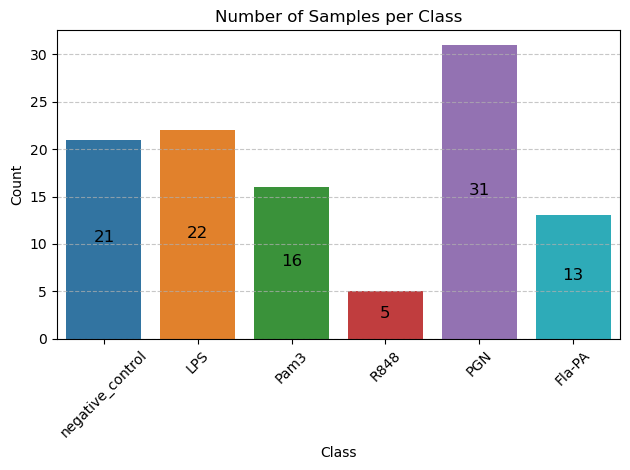

In [90]:
order = ["negative_control", "LPS", "Pam3", "R848", "PGN", "Fla-PA"]
ax = sns.countplot(x=labels, order=order, palette=custom_palette_6)
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("Number of Samples per Class")
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(axis="y", linestyle="--", alpha=0.7)
for container in ax.containers:
    ax.bar_label(container, label_type="center", fontsize=12, padding=1)
save_fig("Number_of_Samples_per_Class")
plt.show()

Select LPS and negative control sample at random

In [30]:
lps_sample = data_wi.loc[data_wi.index.get_level_values("label") == "LPS"].sample(
    n=1, random_state=random_state
)
negative_control_sample = data_wi.loc[
    data_wi.index.get_level_values("label") == "IMDM"
].sample(n=1, random_state=random_state)

negative_control_sample.reset_index(drop=True, inplace=True)
lps_sample.reset_index(drop=True, inplace=True)

processed_negative_control_sample = pipe.transform(negative_control_sample)
processed_lps_sample = pipe.transform(lps_sample)

Load bacterial samples from the all samples dataset

In [ ]:
data_all = pd.read_csv(p / "resources" / "250624_300.csv", index_col=0)
bacterial_data = data_all[data_all.index.str.contains("HKSA|HKEB")]
bacterial_data = bacterial_data.sort_index(
    key=lambda x: x.str.extract(r"(HKSA|HKEB)", expand=False)
)
bac_labels = bacterial_data.index.str.extract(r"(HKSA|HKEB)", expand=False).to_numpy()
bac_labels = np.where(bac_labels == "HKSA", "HK S.aureus", bac_labels)
bac_labels = np.where(bac_labels == "HKEB", "HK E.coli", bac_labels)
bacterial_data.reset_index(drop=True, inplace=True)
bac_unique, counts = np.unique(bac_labels, return_counts=True)
print(dict(zip(bac_unique, counts)))

In [16]:
data_all.index

Index(['BA028_7128_Fla-ST_21', 'BA028_7128_Fla-ST_22', 'BA028_7128_Fla-ST_23',
       'BA028_7128_IMDM_01', 'BA028_7128_IMDM_02', 'BA028_7128_LPS_05',
       'BA028_7128_LPS_06', 'BA028_7128_LPS_07', 'BA028_7128_Pam3_09',
       'BA028_7128_Pam3_10',
       ...
       'MD260_7128_PGN_7', 'MD260_7128_PGN_8', 'MD260_7128_PGN_9',
       'MD260_7128_Pam3-PGN_23', 'MD260_7128_Pam3-low_20',
       'MD260_7128_Pam3-low_21', 'MD260_7128_Pam3_3', 'MD260_7128_Pam3_4',
       'MD260_7128_Pam3_5', 'MD260_7128_Pam3_6'],
      dtype='object', name='samples', length=300)

In [ ]:
data_labels = [my_list[2] for my_list in data_all.index.str.split("_")]

In [23]:
data_uniq, counts = np.unique(data_labels, return_counts=True)
print(dict(zip(data_uniq, counts)))

{'Alb': 6, 'CL307': 8, 'CL8': 3, 'CRX-527': 7, 'FSL-1': 7, 'Fab': 3, 'Fla-PA': 25, 'Fla-ST': 9, 'HKEB': 6, 'HKSA': 6, 'IMDM': 31, 'LPS': 34, 'LPS-PGN': 4, 'LPS-R848': 6, 'LPS-SM': 3, 'LPS-low': 3, 'LTA': 3, 'LTA-BS': 3, 'MPLA': 4, 'Mur': 5, 'PGN': 31, 'Pam2': 6, 'Pam3': 26, 'Pam3-PGN': 4, 'Pam3-R848': 3, 'Pam3-low': 2, 'R848': 17, 'R848-low': 15, 'SCG': 5, 'TL8': 3, 'cAlb': 3, 'clean-nanogam': 3, 'cleared-nanogam': 3, 'contaminated-nanogam': 3}


In [ ]:
processed_bacterial_data = pipe.transform(bacterial_data)
bacterial_data.shape, processed_bacterial_data.shape

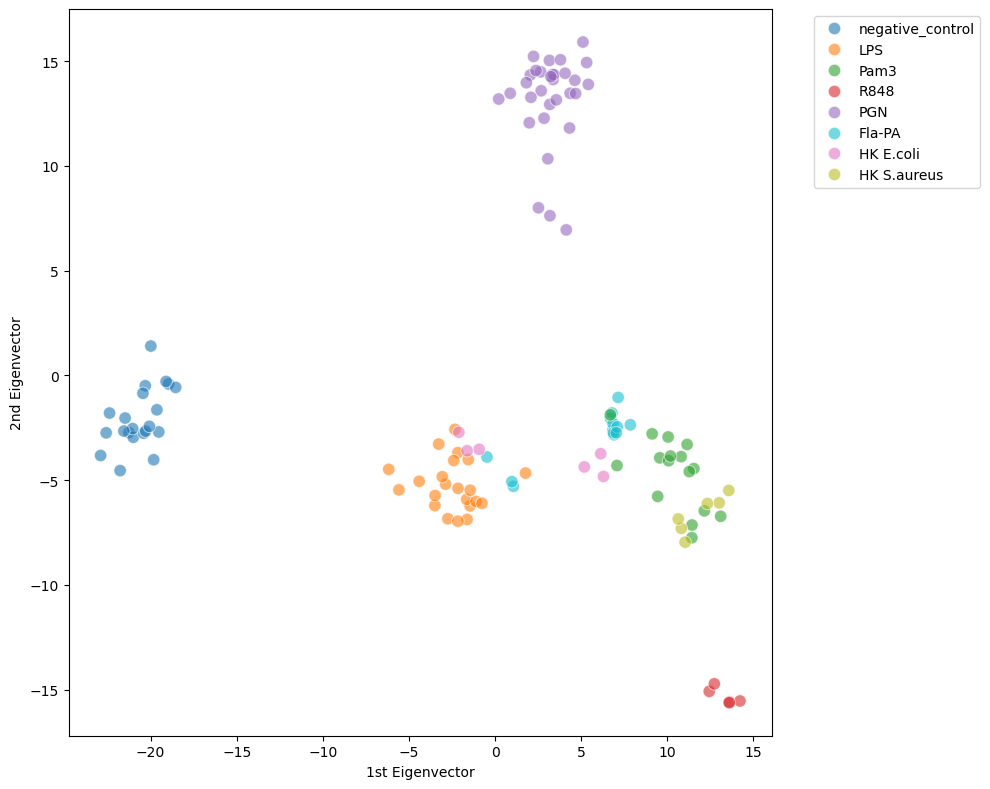

In [ ]:
X_reduced = PCA(n_components=2).fit_transform(data_merged_all)

labels_merged_all = np.concatenate([labels, bac_labels])
data_merged_all = np.vstack([processed_data, processed_bacterial_data])

custom_palette_8 = [
    "#1f77b4",  # Muted Blue
    "#ff7f0e",  # Soft Orange
    "#2ca02c",  # Green
    "#d62728",  # Red
    "#9467bd",  # Purple
    "#17becf",  # Teal/Cyan
    "#e377c2",  # Pink
    "#bcbd22",  # Yellow-Green
]

fig = plt.figure(figsize=(10, 8))

ax = sns.scatterplot(
    x=X_reduced[:, 0],
    y=X_reduced[:, 1],
    hue=labels_merged_all,
    s=80,
    alpha=0.6,
    palette=custom_palette_8,
)

ax.set_xlabel("1st Eigenvector")
ax.set_ylabel("2nd Eigenvector")
ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left", ncol=1)
plt.tight_layout()
save_fig("PCA_wbacterial_data_all")
plt.show()

Finished SMOTE


  0%|          | 0/4 [00:00<?, ?it/s]

Processing LinearSVC


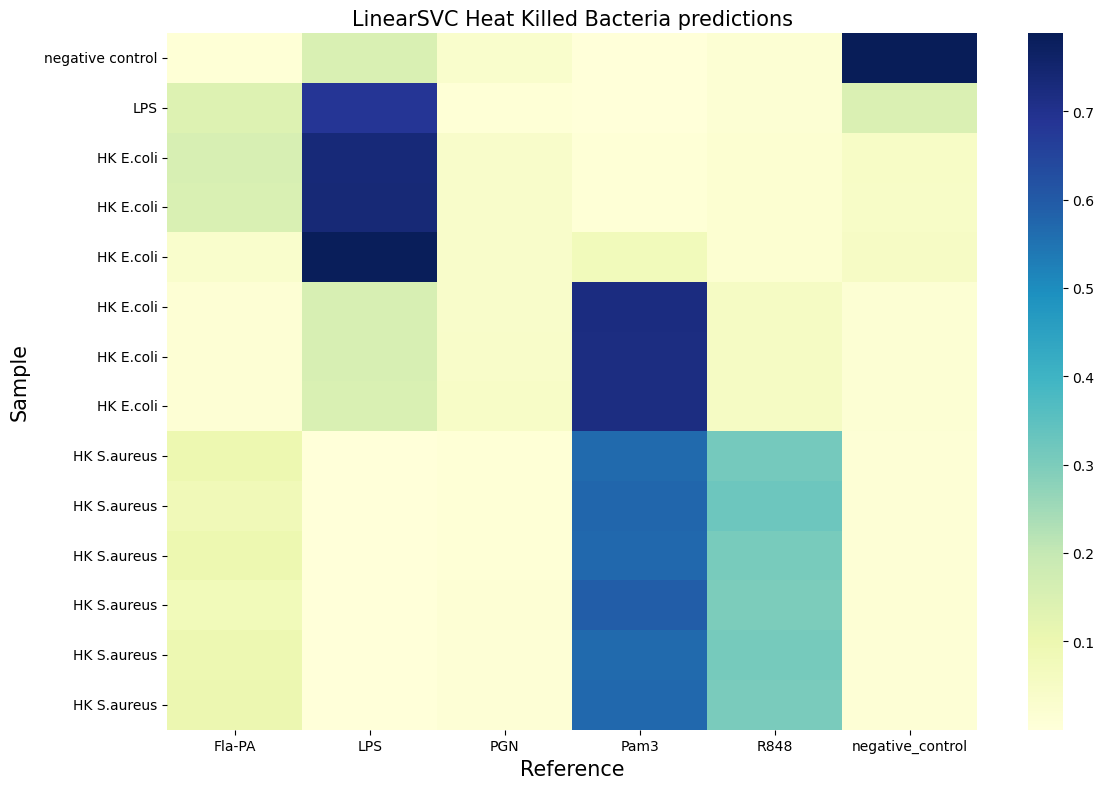

 25%|██▌       | 1/4 [00:01<00:03,  1.29s/it]

Processing RandomForestClassifier


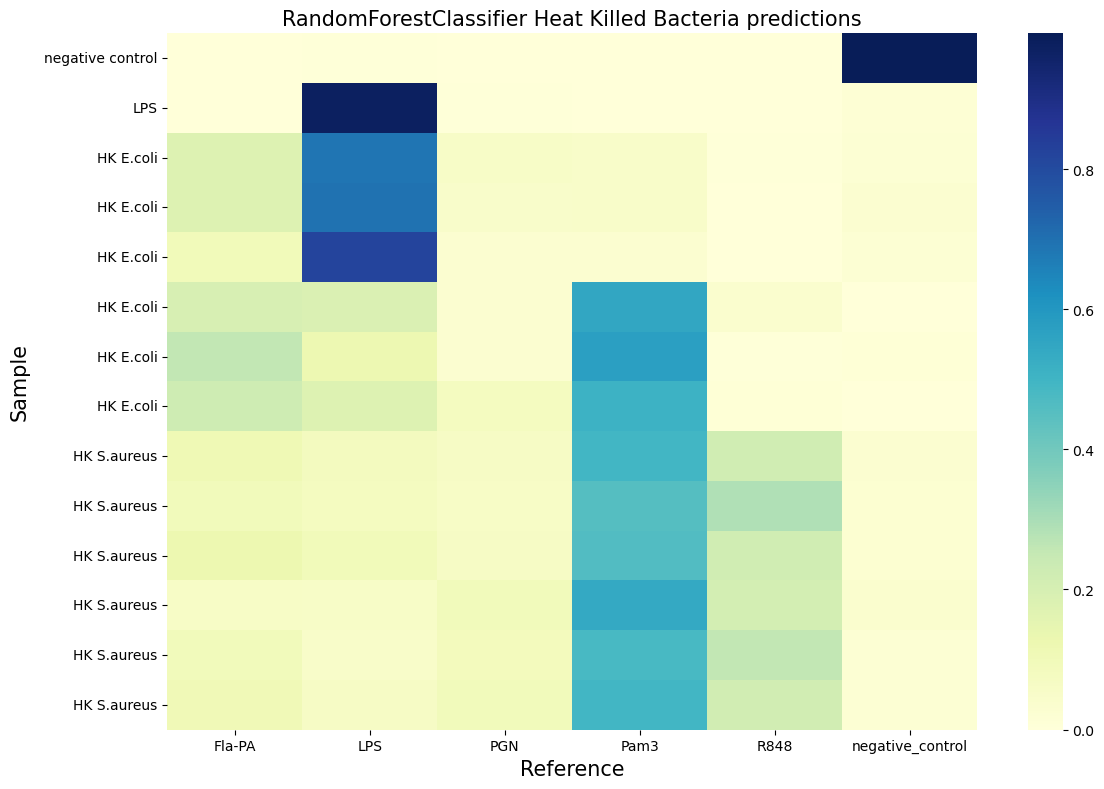

100%|██████████| 4/4 [00:03<00:00,  1.18it/s]


In [56]:
results = []
with parallel_backend("threading", n_jobs=42):
    X, y = sm.fit_resample(processed_data, labels_int)
    if not isinstance(X, np.ndarray):
        X = X.to_numpy()

    print("Finished SMOTE")
    for model_name, model in tqdm(models.items()):
        if model_name == "XGBClassifier" or model_name == "SGDClassifier":
            continue
        print(f"Processing {model_name}")
        model.fit(X, y)

        # Predict probabilities for each sample
        y_pred_positive_control = model.predict_proba(processed_lps_sample)
        y_pred_negative_control = model.predict_proba(processed_negative_control_sample)
        y_pred_bac = model.predict_proba(processed_bacterial_data)

        test_pred = pd.DataFrame(
            np.vstack([y_pred_negative_control, y_pred_positive_control, y_pred_bac]),
            columns=le.classes_,
            index=["negative control", "LPS", *bac_labels],
        )
        make_probability_matrix(model_name, test_pred)